<a target="_blank" href="https://colab.research.google.com/github/jackma-00/house-price-prediction/blob/main/experiments/3_house_price_training_pipeline.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

Install packages

Scikit-learn version 1.6 modified the API around its "tags", and that's the cause of the error

```
AttributeError: 'super' object has no attribute '__sklearn_tags__'
```

 XGBoost has made the necessary changes in PR11021, but at present that hasn't made it into a released version.
 Pin scikit-learn<1.6 until xgboost fix gets released: https://github.com/uber/causalml/pull/809

In [ ]:
!pip show xgboost scikit-learn

In [1]:
!pip uninstall scikit-learn -y

Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0


In [2]:
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 76.0 MB/s eta 0:00:00


In [3]:
!pip uninstall xgboost -y

Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Successfully uninstalled xgboost-2.1.3


In [4]:
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 8.2 MB/s eta 0:00:00


In [ ]:
!pip uninstall hopsworks hsfs hsml -y

In [5]:
!pip install hopsworks[python]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.3/640.3 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### <span style='color:#ff5f27'> Imports

In [6]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import hopsworks
from hopsworks.hsfs.builtin_transformations import label_encoder
from hopsworks import udf
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

import warnings
warnings.filterwarnings("ignore")

### <span style='color:#ff5f27'> Connect to Hopsworks Feature Store

In [7]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
os.environ["HOPSWORKS_API_KEY"] = ""
proj = hopsworks.login()
fs = proj.get_feature_store()


Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1158295


In [8]:
# Retrieve feature groups
properties_fg = fs.get_feature_group(name="properties", version=4)
omi_fg = fs.get_feature_group(name="omi", version=2)

### <span style="color:#ff5f27;"> 🔪 Feature Selection </span>

You will start by selecting all the features you want to include for model training/inference.

In [9]:
selected_features = properties_fg.select([
    'agencyid',
    'bedroomsnumber',
    'buildingyear',
    'codcom',
    'gsm',
    'surface',
    'latitude',
    'longitude',
    'isluxury',
    'isnew',
    'on_the_market',
    'zeroenergybuilding',
    'airconditioning',
    'bathrooms',
    'city',
    'condition',
    'energyclass',
    'ga4heating',
    'garage',
    'heatingtype',
    'pricerange',
    'rooms',
    'price',
]).join(omi_fg.select_all(), on=['id_zona_omi'], join_type='inner')  # Only want rows where a match exists in both tables

In [13]:
# Uncomment this if you would like to view your selected features
selected_features.show(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.54s) 


,agencyid,bedroomsnumber,buildingyear,codcom,gsm,surface,latitude,longitude,isluxury,isnew,...,heatingtype,pricerange,rooms,price,id_zona_omi,tipologia,condizione,compr_min,compr_max,zona_omi_type
0,44970.0,2.0,1960.0,82053.0,80.0,60,38.1095,13.3641,0,1,...,"autonomo, a radiatori, alimentato a metano",fino a 100.000 &euro;,3,95000.0,G273-C4,Ville e Villini,scadente,711.0,996.0,C
1,8564.0,2.0,1970.0,20030.0,1102.0,90,45.1448,10.7997,0,0,...,"centralizzato, a radiatori, alimentato a teler...",fino a 100.000 &euro;,3,75000.0,E897-C2,Ville e Villini,scadente,540.0,774.0,C
2,42221.0,2.0,1970.0,15146.0,86.0,137,45.4662,9.2170,1,1,...,"centralizzato, a pavimento, alimentato a gas",oltre 500.000 &euro;,3,1050000.0,F205-C20,Ville e Villini,scadente,2808.0,4145.0,C
3,197811.0,3.0,1968.0,1272.0,707.0,170,45.0604,7.6602,0,0,...,"centralizzato, a pavimento, alimentato a metano",300.001 - 500.000 &euro;,5+,409000.0,L219-C6,Ville e Villini,scadente,1469.0,2182.0,C
4,23417.0,1.0,2000.0,58091.0,69.0,80,42.0252,12.4537,0,0,...,"autonomo, a pavimento, alimentato a gas",200.001 - 300.000 &euro;,2,235000.0,H501-E96,Ville e Villini,scadente,976.0,1438.0,E


### <span style="color:#ff5f27;"> 🤖 Transformation Functions </span>

In [14]:
transformation_functions = [
    label_encoder("airconditioning"),
    label_encoder("bathrooms"),
    label_encoder("city"),
    label_encoder("condition"),
    label_encoder("energyclass"),
    label_encoder("ga4heating"),
    label_encoder("garage"),
    label_encoder("heatingtype"),
    label_encoder("pricerange"),
    label_encoder("rooms"),
    label_encoder("id_zona_omi"),
    label_encoder("tipologia"),
    label_encoder("condizione"),
    label_encoder("zona_omi_type"),
  ]

## <span style="color:#ff5f27;"> ⚙️ Feature View Creation </span>

In [15]:
feature_view = fs.get_or_create_feature_view(
    name="house_price_fv",
    query=selected_features,
    version=5,
    description="Retrieve data from the Properties and OMI Features groups",
    labels=["price"],
    transformation_functions=transformation_functions,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1158295/fs/1148998/fv/house_price_fv/version/5


## <span style="color:#ff5f27;"> 🏋️ Training Dataset Creation</span>

In [ ]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size=TEST_SIZE,
    description='house price training dataset',
)

In [17]:
X_train

,agencyid,bedroomsnumber,buildingyear,codcom,gsm,surface,latitude,longitude,isluxury,isnew,...,label_encoder_condizione_,label_encoder_energyclass_,label_encoder_ga4heating_,label_encoder_garage_,label_encoder_heatingtype_,label_encoder_id_zona_omi_,label_encoder_pricerange_,label_encoder_rooms_,label_encoder_tipologia_,label_encoder_zona_omi_type_
0,44970.0,2.0,1960.0,82053.0,80.0,60,38.1095,13.36410,0,1,...,0,11,0,12,15,591,4,3,0,1
1,8564.0,2.0,1970.0,20030.0,1102.0,90,45.1448,10.79970,0,0,...,0,11,1,1,62,455,4,3,0,1
2,42221.0,2.0,1970.0,15146.0,86.0,137,45.4662,9.21700,1,1,...,0,8,1,0,47,496,5,3,0,1
3,197811.0,3.0,1968.0,1272.0,707.0,170,45.0604,7.66020,0,0,...,0,8,1,22,48,977,3,6,0,1
5,5537.0,1.0,1970.0,8055.0,1209.0,40,43.8213,7.79729,0,0,...,0,9,1,0,59,903,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,92326.0,5.0,1950.0,87015.0,950.0,200,37.5092,15.07870,0,0,...,0,8,0,1,15,210,3,6,0,0
10903,159085.0,1.0,2013.0,41044.0,172.0,49,43.9043,12.89000,0,0,...,0,6,0,12,15,649,1,2,0,2
10904,10470.0,5.0,1967.0,87015.0,97.0,160,37.5095,15.07920,0,1,...,0,11,0,0,15,210,2,0,0,0
10905,6890.0,2.0,1980.0,41044.0,1355.0,100,43.8974,12.88620,0,0,...,0,11,1,12,59,649,1,3,0,2


In [18]:
y_train

,price
0,95000.0
1,75000.0
2,1050000.0
3,409000.0
5,175000.0
...,...
10902,379000.0
10903,155000.0
10904,230000.0
10905,175000.0


## <span style="color:#ff5f27;"> 🧬 Modeling</span>

In [19]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "house_price_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

(Optional) Perform feature importance analysis to reduce the feature set to the most relevant ones.

### XGBoost's Feature Importance

In [ ]:
# xgb_regressor = XGBRegressor()
# xgb_regressor.fit(X_train, y_train)

# plot_importance(xgb_regressor, importance_type='weight')
# feature_importance_path = images_dir + "/feature_importance_all.png"
# plt.savefig(feature_importance_path)
# plt.show()

(Optional) Remove less important features iteratively and re-train.

### Using Recursive Feature Elimination (RFE)

In [ ]:
# from sklearn.feature_selection import RFE

# xgb_regressor = XGBRegressor()
# selector = RFE(xgb_regressor, n_features_to_select=15, verbose=1)  # Select top 15 features
# X_train_selected = selector.fit_transform(X_train, y_train)

(Optional) Use the reduced X_train_selected for RandomizedSearchCV



In [ ]:
# support = selector.support_

# feature_names = X_train.columns
# selected_features_names = feature_names[support]

# print("Selected Features:")
# print(selected_features_names)

# X_test_selected = X_test[selected_features]

(Optional) Note that the [previous](https://colab.research.google.com/github/jackma-00/house-price-prediction/blob/main/experiments/3_house_price_training_pipeline.ipynb#scrollTo=W09Mxup85UnP&line=3&uniqifier=1) feature selection & feature view step should be addapted to the newly selected features.

### Automate the Search with RandomizedSearchCV

In [42]:
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 1, 5],
    'reg_alpha': [0, 1, 5]
}

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.6, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}


In [43]:
# Predicting target values on the test set
y_pred = best_model.predict(X_test)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 45328631856.206566
R squared: 0.7411123087117708


In [44]:
df = y_test
df['predicted_price'] = y_pred
df = df.sort_values(by="price").reset_index(drop=True)
df.head(5)

,price,predicted_price
0,35000.0,74346.132812
1,42000.0,72859.984375
2,45000.0,82124.078125
3,49000.0,73413.929688
4,58000.0,86287.953125


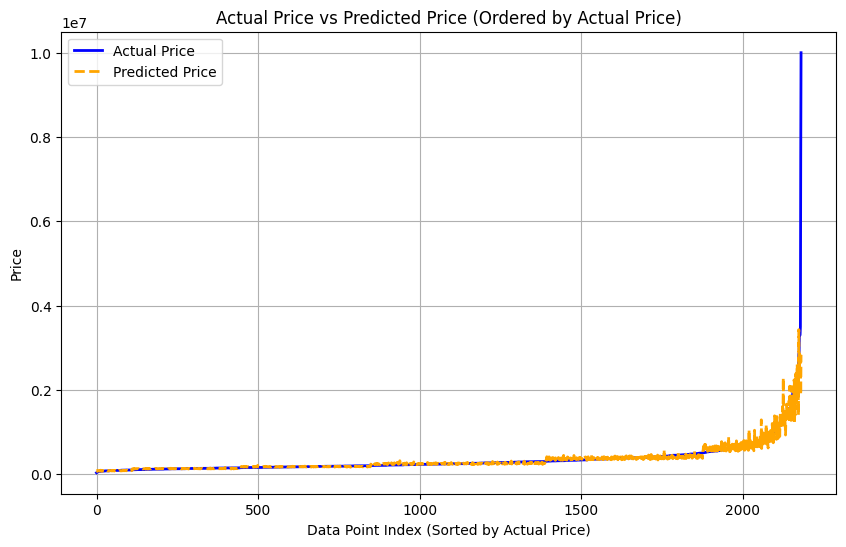

In [45]:
# Plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(df.index, df["price"], label="Actual Price", color='blue', linewidth=2)
plt.plot(df.index, df["predicted_price"], label="Predicted Price", color='orange', linestyle='--', linewidth=2)

# Labels, Title, and Legend
plt.xlabel("Data Point Index (Sorted by Actual Price)")
plt.ylabel("Price")
plt.title("Actual Price vs Predicted Price (Ordered by Actual Price)")
plt.legend()

# Grid
plt.grid(True)

# Save the plot to the desired file path
os.makedirs(images_dir, exist_ok=True)  # Create the directory if it doesn't exist
file_path = images_dir + "/price_hindcast.png"
plt.savefig(file_path, format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

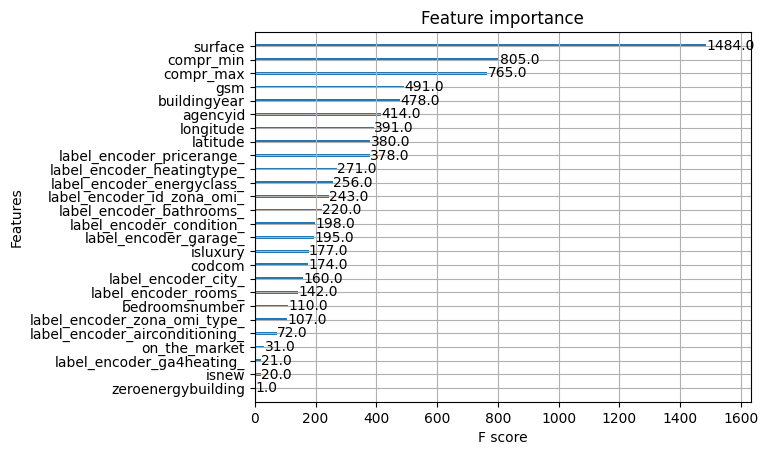

In [47]:
plot_importance(best_model, importance_type='weight')
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

### <span style='color:#ff5f27'> Model Registry

In [48]:
# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [49]:
# Saving the XGBoost regressor object as a json file in the model directory
best_model.save_model(model_dir + "/model.json")

In [50]:
res_dict = {
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [51]:
mr = proj.get_model_registry()

# Creating a Python model in the model registry named 'house_price_xgboost_model'

hp_model = mr.python.create_model(
    name="house_price_xgboost_model",
    metrics=res_dict,
    feature_view=feature_view,                    # Add a feature view to the model
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Italian house price predictor",
)

# Saving the model artifacts to the 'house_price_model' directory in the model registry
hp_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/899561 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/64295 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/139091 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/175 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2379 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1158295/models/house_price_xgboost_model/16


Model(name: 'house_price_xgboost_model', version: 16)